# HW4: Structure-from-motion

Ref:

- https://blog.csdn.net/haizimin/article/details/49836077
- https://github.com/jesolem/PCV/blob/master/pcv_book/sfm.py
- multiple view geometry in computer vision
http://cvrs.whu.edu.cn/downloads/ebooks/Multiple%20View%20Geometry%20in%20Computer%20Vision%20(Second%20Edition).pdf

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import hw3

## 讀取圖片

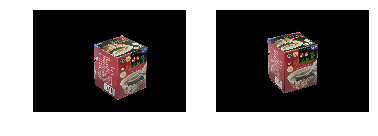

In [2]:
image1 = cv2.imread('./data/Mesona1.JPG')
image2 = cv2.imread('./data/Mesona2.JPG')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image1), plt.axis('off')
plt.subplot(122), plt.imshow(image2), plt.axis('off')
plt.show()

## 計算相機內部參數

In [3]:
intrinsic_matrix1 = np.array([[1.4219, 0.005, 0.5092],
                              [0, 1.4219, 0.3802],
                              [0, 0, 0.0010]])
intrinsic_matrix_inverse1 = np.linalg.inv(intrinsic_matrix1)
print("Intrinsic Matrix\n", intrinsic_matrix1)
print("Inverse Intrinsic Matrix\n", np.transpose(intrinsic_matrix1))

Intrinsic Matrix
 [[  1.42190000e+00   5.00000000e-03   5.09200000e-01]
 [  0.00000000e+00   1.42190000e+00   3.80200000e-01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e-03]]
Inverse Intrinsic Matrix
 [[  1.42190000e+00   0.00000000e+00   0.00000000e+00]
 [  5.00000000e-03   1.42190000e+00   0.00000000e+00]
 [  5.09200000e-01   3.80200000e-01   1.00000000e-03]]


## 計算特徵點

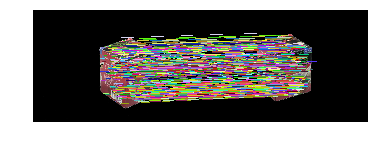

(<matplotlib.image.AxesImage at 0x226d416da20>,
 (-0.5, 2399.5, 799.5, -0.5),
 None)

In [4]:
sift = cv2.xfeatures2d.SIFT_create()

(keypt1, desc1) = sift.detectAndCompute(image1, None)
(keypt2, desc2) = sift.detectAndCompute(image2, None)

BF_MACTHEr_DISTANCE = 0.65
matches = hw3.brute_force_matcher(desc1, desc2, BF_MACTHEr_DISTANCE)
matched_pt_order = hw3.sort_matched_points(matches)

matched_feature_image = hw3.show_matched_image(image1, image2, keypt1, keypt2, matched_pt_order)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()

## 計算Fundamental和Essential矩陣

In [5]:
def get_normalization_matrix(pts):
    '''
        get the normalization matrix
    '''
    x_mean, y_mean = np.mean(pts, axis=0)
    x_var, y_var = np.var(pts, axis=0)    
    x_s, y_s = np.sqrt(2/x_var), np.sqrt(2/y_var)
    n = np.array([[x_s, 0, -x_s*x_mean], 
                  [0, y_s, -y_s*y_mean], 
                  [0, 0, 1]])
    
    return n.astype(np.float64)

def normalization(imgpts1, imgpts2):
    '''
        ref: lecture P.54
    '''
    # t1: image1 normalization matrix, t2: image2 normalization matrix
    t1, t2 = get_normalization_matrix(imgpts1), get_normalization_matrix(imgpts2)
    
    # to homography coordinate
    homopts1 = np.array([ [each[0], each[1], 1.0] for each in imgpts1])
    homopts2 = np.array([ [each[0], each[1], 1.0] for each in imgpts2])
    
    num_of_point = len(imgpts1)
    for i in range(num_of_point): 
        homopts1[i] = np.dot(t1, homopts1[i])
        homopts2[i] = np.dot(t2, homopts2[i])
    
    normalpts1 = np.delete(homopts1, -1, axis=1)
    normalpts2 = np.delete(homopts2, -1, axis=1)
    
    return normalpts1, normalpts2, t1, t2

def denormalize_fundamental_mat(normalmat1, normalmat2, normalize_fundamental):
    '''
        ref: Multiple View Geometry in Computer Vision - Algorithm 11.1
    '''
    transpose_normalmat2 = np.transpose(normalmat2)
    return np.dot(np.dot(transpose_normalmat2, normalize_fundamental), normalmat1)

def get_fundamental(samplept1, samplept2):
    '''
        ref: Multiple View Geometry in Computer Vision - Chapter 11.1, lecture P.50
    '''
    # normalization the key points
    normalpts1, normalpts2, nomalmat1, normalmat2 = normalization(samplept1, samplept2)
    
    A = np.zeros((len(normalpts1), 9), dtype=np.float64)
    for i in range(len(normalpts1)):
        x, y = normalpts1[i][0], normalpts1[i][1]
        xi, yi = normalpts2[i][0], normalpts2[i][1]
        A[i] = np.array([xi*x, xi*y, xi, yi*x, yi*y, yi, x, y, 1])
    
    # resolve det(f) = 0
    u, s, v = np.linalg.svd(A)
    F = v[np.argmin(s)]
    F = F.reshape(3, 3)
    u, s, v = np.linalg.svd(F)
    s = np.array([[s[0], 0 ,0],
                 [0, s[1], 0],
                 [0 , 0, 0]])
    F = np.dot(np.dot(u, s), v)
    
    # homographs coefficient and denormalize the fundamental matrix
    F = F/F[2,2]
    F = denormalize_fundamental_mat(nomalmat1, normalmat2, F)
    F = F/F[2,2]
    
    return F

def get_geometric_error(testpts1, testpts2, fundamentalmat, inliner_threshold):
    '''
        ref: Multiple View Geometry 11.4.3
    '''
    error = 0
    inliner_number = 0
    for i in range(len(testpts1)):
        
        # transform test points to homography coordinate
        x = np.array([testpts1[i][0], testpts1[i][1], 1])
        xi = np.array([testpts2[i][0], testpts2[i][1], 1])
        
        fx = np.dot(fundamentalmat, x)
        ftx = np.dot(np.transpose(fundamentalmat), xi)
        
        m = np.power(np.dot(np.dot(np.transpose(xi), fundamentalmat), x), 2)
        d = np.power(fx[0], 2) + np.power(fx[1], 2) + np.power(ftx[0], 2) + np.power(ftx[1], 2)
        
        distance = m/d
        error += distance
        if(distance < inliner_threshold):
            inliner_number += 1
            
    return error, inliner_number

def get_essential_mat(intrinsicmat1, intrinsicmat2, fundamentalmat):
    '''
        ref: Multiple View Geometry 9.12
    '''
    return np.transpose(intrinsicmat2) * fundamentalmat * intrinsicmat1

def find_fundamental_by_RANSAC(matchedpt_order, imgpts1, imgpts2, inliner_threshold):
    '''
        ref: Multiple View Geometry 11.6
    '''
    print("Key Point Number\n", len(imgpts1))
    ransac_iteration = 5000
    ransac_sample_number = 8
    
    best_error = 0
    best_fundamental = np.zeros((3,3))
    best_inlinernum = 0
    best_sampts1, best_sampts2 = hw3.sample_match_points(matchedpt_order, imgpts1, imgpts2, ransac_sample_number)
    for i in range(ransac_iteration):
        sampts1, sampts2 = hw3.sample_match_points(matchedpt_order, imgpts1, imgpts2, ransac_sample_number)
        f = get_fundamental(sampts1, sampts2)
        error, inlinernum = get_geometric_error(imgpts1, imgpts2, f, inliner_threshold)
        if(inlinernum > best_inlinernum):
            best_error = error
            best_fundamental = f
            best_inlinernum = inlinernum
            best_sampts1, best_sampts2 = sampts1, sampts2
    best_essential = get_essential_mat(intrinsic_matrix1, intrinsic_matrix1, best_fundamental)
    print("RANSC Error\n", best_error)
    print("Inliner Number\n", best_inlinernum)
    return best_fundamental, best_essential, best_sampts1, best_sampts2 

RANSAC_INLINER_THRESHOLD = 0.25

# find the fundamnetal matrix
imgpts1, imgpts2 = hw3.get_matched_points(matched_pt_order, keypt1, keypt2)
fundamentamat, essentialmat, sampt1, sampt2 = find_fundamental_by_RANSAC(matched_pt_order, imgpts1, imgpts2, RANSAC_INLINER_THRESHOLD)
print("F\n", fundamentamat)
print("E\n", essentialmat)

# by opencv
fundamentalmat_opencv, _ = cv2.findFundamentalMat(imgpts1, imgpts2, cv2.RANSAC, RANSAC_INLINER_THRESHOLD, 0.99, None)
essentialmat_opencv = get_essential_mat(intrinsic_matrix1, intrinsic_matrix1, fundamentalmat_opencv)
cv_error, cv_inlinernum = get_geometric_error(imgpts1, imgpts2, fundamentalmat_opencv, RANSAC_INLINER_THRESHOLD)
print("CV RANSC Error\n", cv_error)
print("CV Inliner Number\n", cv_inlinernum)
print("F by opencv\n", fundamentalmat_opencv)
print("E by opencv\n", essentialmat_opencv)

Key Point Number
 595
RANSC Error
 462334.082995
Inliner Number
 356
F
 [[  2.48143757e-07   7.79742414e-07  -2.88795862e-03]
 [ -2.29550215e-06   1.76834088e-07   2.03238522e-02]
 [  1.72396506e-03  -1.89363322e-02   1.00000000e+00]]
E
 [[  5.01696952e-07   0.00000000e+00  -0.00000000e+00]
 [ -0.00000000e+00   3.57523091e-07   0.00000000e+00]
 [  0.00000000e+00  -0.00000000e+00   1.00000000e-06]]
CV RANSC Error
 464259.889443
CV Inliner Number
 297
F by opencv
 [[ -2.74195568e-07  -4.23822101e-06   2.42692527e-04]
 [  3.82607993e-06  -5.82756139e-08   1.34771046e-02]
 [ -7.89958582e-04  -1.32662627e-02   1.00000000e+00]]
E by opencv
 [[ -5.54368492e-07  -0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -1.17821613e-07   0.00000000e+00]
 [ -0.00000000e+00  -0.00000000e+00   1.00000000e-06]]


## Draw Epipolar Lines

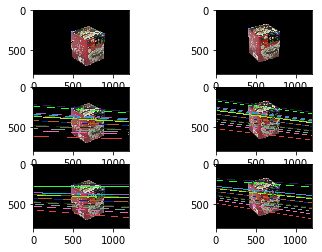

In [6]:
def compute_correspond_epilines(keypts, which_image, fundamental):
    '''
        ref: https://github.com/opencv/opencv/blob/f5801ee7dac4114ac2995a5fd3866ac7775752f7/modules/calib3d/src/fundam.cpp#L836
        l = Fx'
        l' = F^Tx
    '''
    lines = np.zeros((len(keypts), 3))
    
    if (which_image == 2):
        fundamental = np.transpose(fundamental)
    
    for i, p in enumerate(keypts):
        hp = np.array([p[0], p[1], 1])
        l = np.dot(fundamental, np.transpose(hp))
        
        a, b, c = l[0], l[1], l[2]
        check = a*a + b*b
        if check != 0:
            check = np.sqrt(check)
        else:
            check = 1
        lines[i] = np.array([a/check, b/check ,c/check])
        
    return lines

def draw_epilines(img1, img2, lines, pts1, pts2, colors):
    '''
        ref: https://docs.opencv.org/3.4.4/da/de9/tutorial_py_epipolar_geometry.html
        x0, y0 = (0, -b/c)
        x1, y1 = (w, -(aw+c)/b)
    '''
    imgA = np.copy(img1)
    imgB = np.copy(img2)
    h, w, _ = img1.shape
    
    i=0
    for r,pt1, pt2 in zip(lines, pts1, pts2):
        x0, y0 = (0, int(-r[2]/r[1]))
        x1, y1 = (w, int(-(r[0]*w+r[2])/r[1]))
        imgA = cv2.line(imgA, (x0, y0), (x1, y1), colors[i], 5)
        imgA = cv2.circle(imgA, (int(pt1[0]), int(pt1[1])), 15, colors[i], -1)
        imgB = cv2.circle(imgB, (int(pt2[0]), int(pt2[1])), 15, colors[i], -1)
        i += 1
    return imgA, imgB

colors = np.zeros((len(sampt1), 3))
for i in range(len(sampt1)):
    colors[i] = tuple(np.random.randint(0, 255, 3).tolist())

# show image epilines
lines1 = compute_correspond_epilines(sampt2, 2, fundamentamat)
img3, _ = draw_epilines(image1, image2, lines1, sampt1, sampt2, colors)
lines2 = compute_correspond_epilines(sampt1, 1, fundamentamat)
img4, _ = draw_epilines(image2, image1, lines2, sampt2, sampt1, colors)

# by opencv
lines3 = cv2.computeCorrespondEpilines(sampt2, 2, fundamentalmat_opencv)
lines3 = lines3.reshape(-1,3)
img5, _ = draw_epilines(image1, image2, lines3, sampt1, sampt2, colors)
lines4 = cv2.computeCorrespondEpilines(sampt1, 1, fundamentalmat_opencv)
lines4 = lines4.reshape(-1,3)
img6, _ = draw_epilines(image2, image1, lines4, sampt2, sampt1, colors)

plt.subplot(321), plt.imshow(image1)
plt.subplot(322), plt.imshow(image2)
plt.subplot(323), plt.imshow(img3)
plt.subplot(324), plt.imshow(img4)
plt.subplot(325),plt.imshow(img5)
plt.subplot(326),plt.imshow(img6)
plt.show()

## 計算Camera Matrix

In [7]:
# first camera matrix (ref: Multiple View Geometry 9.19)
cammat1 = np.array([[1,0,0,0],
                           [0,1,0,0],
                           [0,0,1,0]])

def check_coherent_rotatio(rotation):
    '''
        We can install a check to see if the
        rotation element is a valid rotation matrix. Keeping in mind that rotation matrices must have a
        determinant of 1 (or -1)
    '''
    if((abs(np.linalg.det(rotation)) - 1.0) > 1e-07):
        return False
    return True

def get_camera_matrix(R, T):
    camera_matrix = np.zeros((4, 3))
    if(check_coherent_rotatio(R) == True):
        camera_matrix = np.array([[R[0,0], R[0,1], R[0,2], T[0]],
                           [R[1,0], R[1,1], R[1,2], T[1]],
                           [R[2,0], R[2,1], R[2,2], T[2]]])
    return camera_matrix

_u, _s, _vt = np.linalg.svd(essentialmat)
#print("u\n", _u, "\ns\n", _s, "\nvh\n", _vt)

# skew-symmetric (ref: Multiple View Geometry 9.13)
w = np.array([[0, -1, 0], 
              [1, 0, 0], 
              [0, 0, 1]])

# Thre have four camera direction (ref: Multiple View Geometry 9.14)
cammat2_1 = get_camera_matrix(np.dot(np.dot(_u, w), _vt), _u[:,2])
cammat2_2 = get_camera_matrix(np.dot(np.dot(_u, w), _vt), -_u[:,2])
cammat2_3 = get_camera_matrix(np.dot(np.dot(_u, np.transpose(w)), _vt), _u[:,2])
cammat2_4 = get_camera_matrix(np.dot(np.dot(_u, np.transpose(w)), _vt), -_u[:,2])

print("camera matrix2 1\n", cammat2_1)
print("camera matrix2 2\n", cammat2_2)
print("camera matrix2 3\n", cammat2_3)
print("camera matrix2 4\n", cammat2_4)

camera matrix2 1
 [[ 0.  0.  1.  0.]
 [ 0.  1.  0.  1.]
 [-1.  0.  0.  0.]]
camera matrix2 2
 [[ 0.  0.  1. -0.]
 [ 0.  1.  0. -1.]
 [-1.  0.  0. -0.]]
camera matrix2 3
 [[ 0.  0. -1.  0.]
 [ 0.  1.  0.  1.]
 [ 1.  0.  0.  0.]]
camera matrix2 4
 [[ 0.  0. -1. -0.]
 [ 0.  1.  0. -1.]
 [ 1.  0.  0. -0.]]


## 將像素對應到三維空間

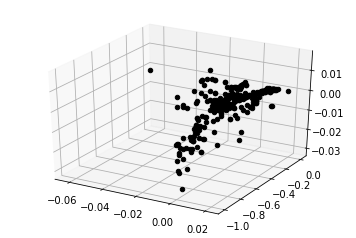

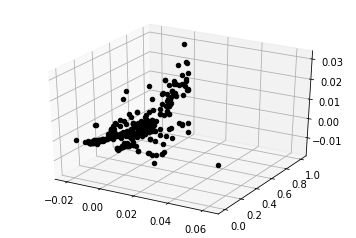

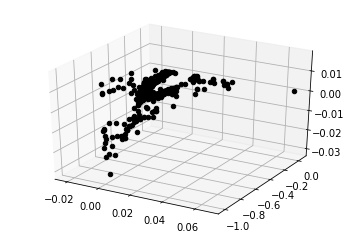

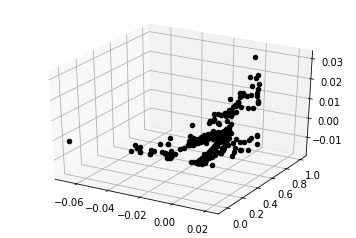

In [10]:
def linear_LS_Triangulation(x1, camera_matrix1, x2, camera_matrix2):
    '''
        ref: 1995 Triangulation, ch5.1 Linear Triangulation
        https://perception.inrialpes.fr/Publications/1997/HS97/HartleySturm-cviu97.pdf
    '''
    A = np.array([[(x1[0]*camera_matrix1[2,0]-camera_matrix1[0,0]), (x1[0]*camera_matrix1[2,1]-camera_matrix1[0,1]), (x1[0]*camera_matrix1[2,2]-camera_matrix1[0,2])],
                  [(x1[1]*camera_matrix1[2,0]-camera_matrix1[1,0]), (x1[1]*camera_matrix1[2,1]-camera_matrix1[1,1]), (x1[1]*camera_matrix1[2,2]-camera_matrix1[1,2])],
                  [(x2[0]*camera_matrix2[2,0]-camera_matrix2[0,0]), (x2[0]*camera_matrix2[2,1]-camera_matrix2[0,1]), (x2[0]*camera_matrix2[2,2]-camera_matrix2[0,2])],
                  [(x2[1]*camera_matrix2[2,0]-camera_matrix2[1,0]), (x2[1]*camera_matrix2[2,1]-camera_matrix2[1,1]), (x2[1]*camera_matrix2[2,2]-camera_matrix2[1,2])]])
    
    B = np.array([-(x1[0]*camera_matrix1[2,3]-camera_matrix1[0,3]),
                -(x1[1]*camera_matrix1[2,3]-camera_matrix1[1,3]),
                -(x2[0]*camera_matrix2[2,3]-camera_matrix2[0,3]),
                -(x2[1]*camera_matrix2[2,3]-camera_matrix2[1,3])])
    
    retbal, dst = cv2.solve(A,B, flags=cv2.DECOMP_SVD)
    return retbal, dst

def triangulate_points(keypt1, keypt2, camera_matrix1, camera_matrix2):
    
    points = np.zeros((len(keypt1), 3))
    reproject_errors = np.zeros(len(keypt1))
    for i in range(len(keypt1)):
    
        # convert to normalized homogeneous coordinates
        kp1 = keypt1[i]
        x1 = np.array([kp1[0], kp1[1], 1])
        x1m = np.dot(intrinsic_matrix_inverse1, x1)
        x1 = x1m
        
        # convert to normalized homogeneous coordinates
        kp2 = keypt2[i]
        x2 = np.array([kp2[0], kp2[1], 1])
        x2m = np.dot(intrinsic_matrix_inverse1, x2)
        x2 = x2m

        # triangulate
        state, X = linear_LS_Triangulation(x1, camera_matrix1, x2, camera_matrix2)
        points[i] = X[:,0]
        
    return points

def show_cloud_points(pts):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i, p in enumerate(pts):
        xs = pts[i][0]
        ys = pts[i][1]
        zs = pts[i][2]
        ax.scatter(xs, ys, zs, color='black')
    plt.show()

cloudpts1 = triangulate_points(imgpts1, imgpts2, cammat1, cammat2_1)
cloudpts2 = triangulate_points(imgpts1, imgpts2, cammat1, cammat2_2)
cloudpts3 = triangulate_points(imgpts1, imgpts2, cammat1, cammat2_3)
cloudpts4 = triangulate_points(imgpts1, imgpts2, cammat1, cammat2_4)

show_cloud_points(cloudpts1)
show_cloud_points(cloudpts2)
show_cloud_points(cloudpts3)
show_cloud_points(cloudpts4)

## 測試第二圖

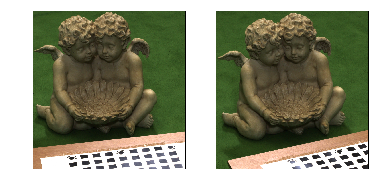

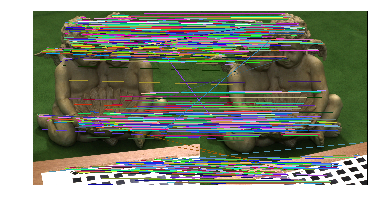

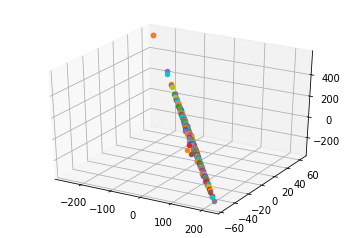

In [9]:
image3 = cv2.imread('./data/Statue1.bmp')
image4 = cv2.imread('./data/Statue2.bmp')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image3), plt.axis('off')
plt.subplot(122), plt.imshow(image4), plt.axis('off')
plt.show()

# get feature points
sift2 = cv2.xfeatures2d.SIFT_create()
(keypt3, desc3) = sift.detectAndCompute(image3, None)
(keypt4, desc4) = sift.detectAndCompute(image4, None)
BF_MACTHER_DISTANCE = 0.65
matches2 = hw3.brute_force_matcher(desc3, desc4, BF_MACTHER_DISTANCE)
matched_pt_order2 = hw3.sort_matched_points(matches2)
matched_feature_image = hw3.show_matched_image(image3, image4, keypt3, keypt4, matched_pt_order2)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()
imgpts3, imgpts4 = hw3.get_matched_points(matched_pt_order2, keypt3, keypt4)

cammat3 = np.array([[0.140626, 0.989027, -0.045273, 67.479439],
                  [0.475766, -0.107607, -0.872965, -6.020049],
                  [-0.868258, 0.101223, -0.485678, 40.224911]])

cammat4 = np.array([[0.336455, 0.940689, -0.043627, 62.882744],
                  [0.446741, -0.200225, -0.871970, -21.081516],
                  [-0.828988, 0.273889, -0.487611, 40.544052]])

cloudpts = triangulate_points(imgpts3, imgpts4, cammat3, cammat4)
show_cloud_points(cloudpts)